In [1]:
# import libraries
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import torch
from torch import nn
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import sys
sys.path.append("./src")
from perceptron import MLP

## Pull in Data
Due to the fact that the MNST dataset is actually somewhat large, it's source format is compressed and can actually be challenging to process without some nice helper libraries.  `PyTorch` provides such libraries (as does basically every NN library).  We're creating two datasets, `train_data` and `test_data`, simply by changing the configuration option from `train=True` to `train=False`.

The first time you execute this cell, it takes a little longer to run as it has to download the data, but once you've done that it will check the location you specify and run much quicker if you revisit this notebook.

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

## Basic Visualization
We'll go ahead and visualize some of the data.  It's useful as it gives us a sense of how to work with our itterators, as well as making sure we've successfully aquired the data.

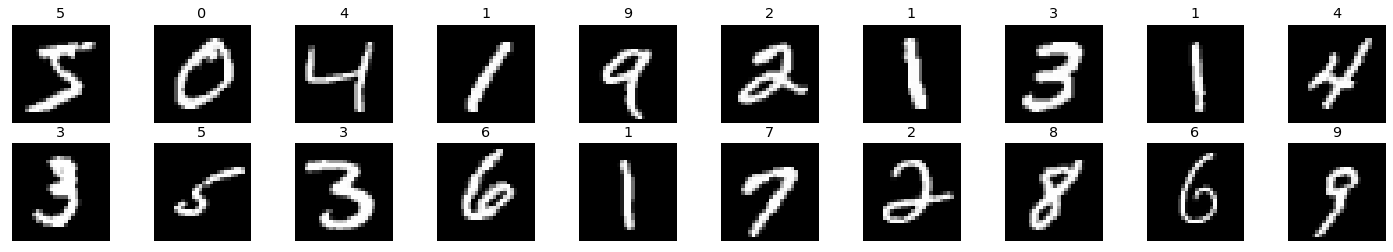

In [3]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

## Alternative Viz
Here's an alternative visualization, it's pretty nice as it shows the actual values for a single image.

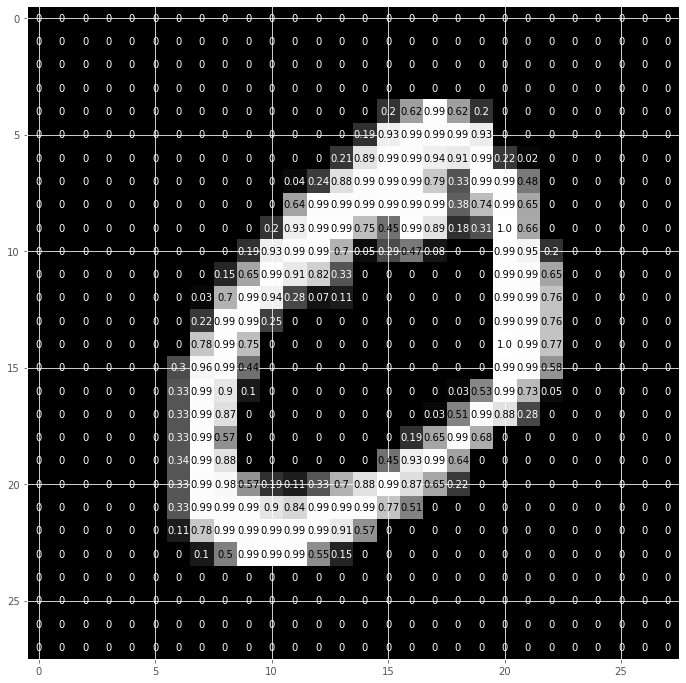

In [4]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

## Initialize a model object
You should already have looked over the `MLP` definition.  We'll create a model with an embedding dimension of 300.  The question is, what is our expectation with our overall training effectiveness and this size?  Of course for a perceptron, we don't have to have the same number of input and output layers in our intermediate step, but it is useful in setting up the next part of the problem.

In [5]:
# initialize the NN
model = MLP(embedding_dim = 300)
print(model)

MLP(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


## Specify Training Parameters
Interestingly, `PyTorch` does not tie training parameters to the model class itself.  This actually makes fine tuning easier as you can specify a new optimizer after your initial training run.  We won't be doing that in this assignment as we'll be pressed for time, but know that specifying your Loss function and optimization correctly will be very important for the next steps.

In [6]:
## Specify loss and optimization functions
# specify loss function
criterion = nn.NLLLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.05)

## Train the network
Here, we're probably undertraining the network a bit, but we'd like this to run quickly so we can move onto the new content for the day. 

In [7]:
# number of epochs to train the model
n_epochs = 20  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.367289
Epoch: 2 	Training Loss: 0.132217
Epoch: 3 	Training Loss: 0.086575
Epoch: 4 	Training Loss: 0.062849
Epoch: 5 	Training Loss: 0.047492
Epoch: 6 	Training Loss: 0.035828
Epoch: 7 	Training Loss: 0.026941
Epoch: 8 	Training Loss: 0.020111
Epoch: 9 	Training Loss: 0.015104
Epoch: 10 	Training Loss: 0.011577
Epoch: 11 	Training Loss: 0.008509
Epoch: 12 	Training Loss: 0.006663
Epoch: 13 	Training Loss: 0.004999
Epoch: 14 	Training Loss: 0.004476
Epoch: 15 	Training Loss: 0.003081
Epoch: 16 	Training Loss: 0.002308
Epoch: 17 	Training Loss: 0.001852
Epoch: 18 	Training Loss: 0.001492
Epoch: 19 	Training Loss: 0.001253
Epoch: 20 	Training Loss: 0.001079


## Evaluate the Network
We'll see our classification accuaracy over a number of instances.  Note, that the problem for the next section is going to be very different, so your code for evealuation will end up being quite different.

In [8]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.076177

Test Accuracy of     0: 99% (971/980)
Test Accuracy of     1: 99% (1127/1135)
Test Accuracy of     2: 98% (1014/1032)
Test Accuracy of     3: 97% (988/1010)
Test Accuracy of     4: 98% (967/982)
Test Accuracy of     5: 98% (876/892)
Test Accuracy of     6: 98% (939/958)
Test Accuracy of     7: 97% (1007/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 97% (982/1009)

Test Accuracy (Overall): 98% (9819/10000)


## Vizualizing Results
As always, it's useful to visualize the results to see where our network does well, and where it struggles.

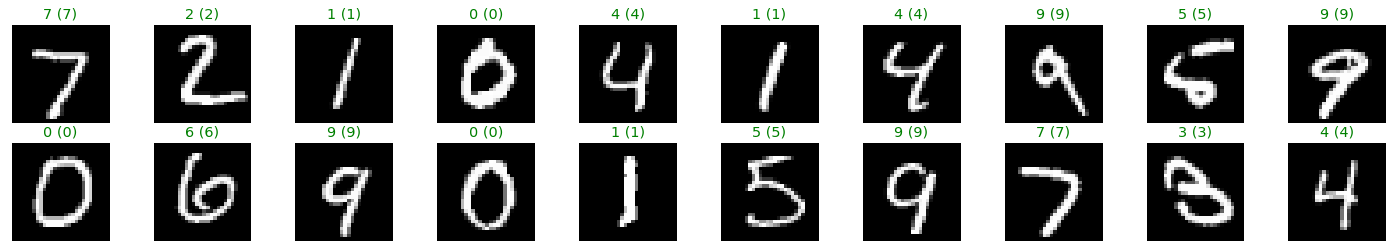

In [9]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))